In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [4]:
# Loading dataset into kaggle
df = pd.read_csv('../input/us-accidents/US_Accidents_May19.csv') 
df.head()

FileNotFoundError: [Errno 2] File b'../input/us-accidents/US_Accidents_May19.csv' does not exist: b'../input/us-accidents/US_Accidents_May19.csv'

In [ ]:
# Restrict observations to Ohio for preliminary analysis
df = df.loc[df['State']=='OH']
df['ID'].count()

In [ ]:
# Generate a county ID 
df['County'] = df['County'].astype('category')
df['County_ID'] = df['County'].cat.codes
df = df.set_index('County_ID')
df.head()

In [ ]:
# Drop columns that will not be used (prior to trimming)
df = df.drop(['Timezone','Airport_Code','Weather_Timestamp','Sunrise_Sunset','Wind_Chill(F)','Nautical_Twilight','Astronomical_Twilight','End_Lat','End_Lng'],axis=1)
df.shape

In [ ]:
# Replace true and false with numeric values
df = df.replace(False,0)
df = df.replace(True,1)

df = df.replace('Night',0)
df = df.replace('Day',1)

df = df.replace('MapQuest',0)
df = df.replace('Bing',1)
df = df.replace('MapQuest-Bing',2)


In [ ]:
# Replace missing values
## If rain is missing it is equal to zero and same with wind speed. 
df['Precipitation(in)'].fillna(0,inplace=True)
df['Wind_Speed(mph)'].fillna(0,inplace=True)

In [ ]:
# Check data types and make edits where needed
df.dtypes

Data types are good to go.

In [ ]:
# Look at some correlations
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
# Check the correlations between some variables of interest
corr_df = df[['Severity','Distance(mi)','Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']].corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

The graph above seems to indicate that no isolated variables are correlated with accident severity. Distance has a weak correlation, but that is not surprising since dinstance represents traffic slowdown. More severe accidents should lead to lengthier traffic. 

I will create a variable to distinguish between highway roads and non-highway roads. Hopefully, this correlation matrix may provide slightly more insight.

In [ ]:
#Create a highway indicator variable 
df['Description']=df['Description'].astype(str)
df['Highway'] = 0

df.loc[df['Description'].str.contains('I-'), 'Highway'] = 1
df.loc[df['Description'].str.contains('OH-'), 'Highway'] = 1
df.loc[df['Description'].str.contains('US-'), 'Highway'] = 1
df.loc[df['Description'].str.contains('Hwy-'), 'Highway'] = 1

In [ ]:
#Re-run previous correlation analysis including highway
corr_df = df[['Severity','Distance(mi)','Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Highway']].corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

As seen above, adding *highway* to the variable list generates the highest correlative variable which should help in the feature selection process.

**Feature Selection w/ Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
# Drop variables that don't make sense in our context 
df = df.drop(['TMC','Source','ID','Start_Lat','Start_Lng','Distance(mi)',
              'Description','Number','Street','Side','City','County','State'
              ,'Zipcode','Country','End_Time'],axis=1)

In [ ]:
# Need to parse out days, month, year, and time from Start_Time
temp = df['Start_Time'].str.split(" ", n = 1, expand = True)

# Time in minutes
temp2 = temp[1].str.split(":",n=2,expand=True)
temp2 = temp2.drop(2,axis=1)
temp2[0] = temp2[0].astype(int)*60
temp2[1] = temp2[1].astype(int)
temp2['Min'] = temp2[0]+temp2[1]

# Date stripped to day month and year
temp3 = temp[0].str.split("-",n=2,expand=True)
temp3.rename(columns={0:'Year',1:'Month',2:'Day'},inplace=True)

# Drop start_time and merge new specifiec data
df = df.drop('Start_Time',axis=1)
df['Min'] = temp2['Min']
df['Year'] = temp3['Year'].astype(int)
df['Month']= temp3['Month'].astype(int)
df['Day'] = temp3['Day'].astype(int)

df.head()

In [ ]:
# Drop if weather condition missing
df['Weather_Condition'] = df['Weather_Condition'].astype(str)
df = df.loc[df['Weather_Condition']!='nan']
df['Weather_Condition'].unique()

In [ ]:
# Create weather dummies 
df['Rain'] = 0
df['Severe_Weather'] = 0 # Thunderstorm w/ rain, Hail, includes "Heavy", squalls
df['Snow'] = 0 
df['Clear'] = 0 
df['Cloudy'] = 0

# Do not assign fog, since it is captured by visibility
df.loc[df['Weather_Condition'].str.contains('Light Rain|Rain|Light Freezing Drizzle|Light Drizzle|Heavy Rain|Light Freezing Rain|Drizzle|Light Rain Showers|Light Thunderstorms and Rain|Heavy Thunderstorms and Rain|Thunderstorms and Rain|Mist|Rain Showers|Heavy Drizzle|Squalls'),'Rain'] = 1
df.loc[df['Weather_Condition'].str.contains('Light Snow|Snow|Heavy Snow|Blowing Snow|Squalls|Light Ice Pellets|Light Thunderstorms and Snow|Light Snow Showers|Small Hail|Snow Showers'),'Snow'] = 1
df.loc[df['Weather_Condition'].str.contains('Scattered Clouds|Clear'),'Clear'] = 1
df.loc[df['Weather_Condition'].str.contains('Overcast|Mostly Cloudy|Partly Cloudy'),'Cloudy'] = 1
df.loc[df['Weather_Condition'].str.contains('Heavy Rain|Heavy Thunderstorms and Rain|Heavy Snow|Squalls'),'Severe_Weather'] = 1
df = df.drop(['Weather_Condition','Wind_Direction'],axis=1)
df.head()

In [ ]:
# Train and test split 
from sklearn.model_selection import train_test_split as split
import matplotlib.pyplot as plt
df = df.fillna(0)
y = df['Severity']
X = df.loc[:,'Temperature(F)':'Cloudy']
X_train, X_test, y_train, y_test = split(X, y, random_state=0)

In [55]:
# Random Forest 
forest = RandomForestClassifier(n_estimators=25,test_size=.25,random_state=0)
forest.fit(X_train,y_train)
print('The training accuracy score is: {:.3f}'.format(forest.score(X_train,y_train)))
print('The test accuracy score is: {:.3f}'.format(forest.score(X_test,y_test)))
X_train.head()

The training accuracy score is: 0.996
The test accuracy score is: 0.799


,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,...,Highway,Min,Year,Month,Day,Rain,Severe_Weather,Snow,Clear,Cloudy
728927,30.2,92.0,30.12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,311,2018,12,24,0,0,0,0,1
1490381,50.0,89.0,30.12,10.0,5.8,0.0,0.0,0.0,0.0,0.0,...,0,730,2017,11,9,0,0,0,0,1
1918880,47.3,71.0,30.00,10.0,8.1,0.0,0.0,0.0,0.0,0.0,...,1,143,2017,5,3,0,0,0,0,1
1335842,52.0,83.0,30.18,10.0,6.9,0.0,0.0,0.0,0.0,0.0,...,1,929,2018,2,20,0,0,0,0,1
268316,51.8,82.0,29.90,3.0,6.9,0.0,0.0,0.0,0.0,0.0,...,0,551,2017,1,5,0,0,0,0,1


**Extend to entire dataset**

In [46]:
# Load dataset 
df = pd.read_csv('../input/us-accidents/US_Accidents_May19.csv') 

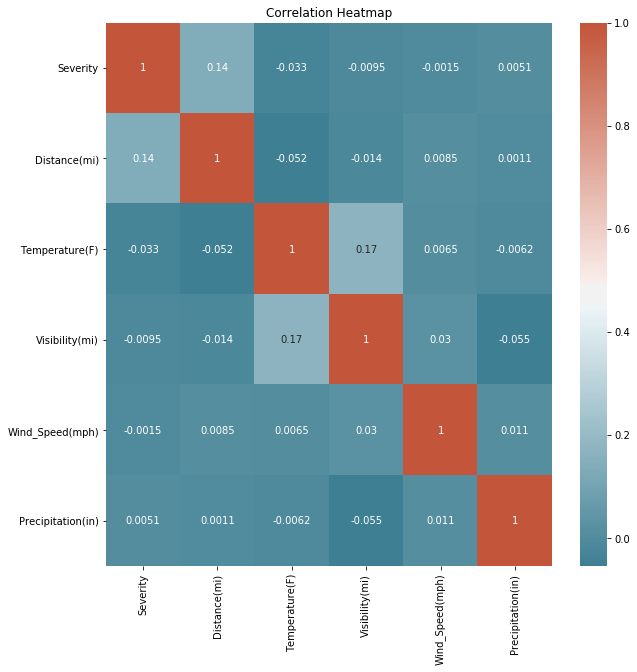

In [47]:
# Drop columns that will not be used (prior to trimming)
df = df.drop(['Timezone','Airport_Code','Weather_Timestamp','Sunrise_Sunset','Wind_Chill(F)','Nautical_Twilight','Astronomical_Twilight','End_Lat','End_Lng'],axis=1)

# Replace true and false with numeric values
df = df.replace(False,0)
df = df.replace(True,1)

df = df.replace('Night',0)
df = df.replace('Day',1)

df = df.replace('MapQuest',0)
df = df.replace('Bing',1)
df = df.replace('MapQuest-Bing',2)

# Replace missing values
## If rain is missing it is equal to zero and same with wind speed. 
df['Precipitation(in)'].fillna(0,inplace=True)
df['Wind_Speed(mph)'].fillna(0,inplace=True)

# Look at some correlations
import matplotlib.pyplot as plt 
import seaborn as sns

# Check the correlations between some variables of interest
corr_df = df[['Severity','Distance(mi)','Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']].corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

In [49]:
#Create a highway indicator variable 
df['Description']=df['Description'].astype(str)
df['Highway'] = 0

df.loc[df['Description'].str.contains('I-'), 'Highway'] = 1
df.loc[df['Description'].str.contains('US-'), 'Highway'] = 1
df.loc[df['Description'].str.contains('Hwy-'), 'Highway'] = 1

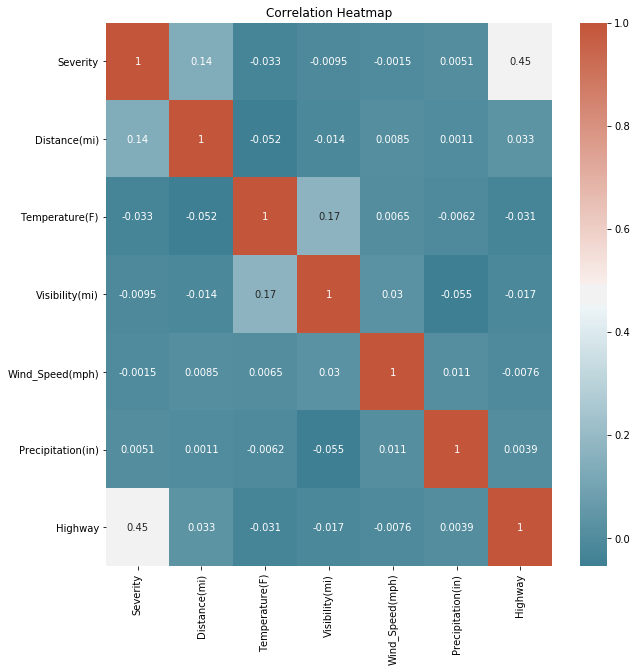

In [50]:
#Re-run previous correlation analysis including highway
corr_df = df[['Severity','Distance(mi)','Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Highway']].corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

In [51]:
from sklearn.ensemble import RandomForestClassifier 

# Drop variables that don't make sense in our context 
df = df.drop(['TMC','Source','ID','Start_Lat','Start_Lng','Distance(mi)',
              'Description','Number','Street','Side','City','County','State'
              ,'Zipcode','Country','End_Time'],axis=1)

# Need to parse out days, month, year, and time from Start_Time
temp = df['Start_Time'].str.split(" ", n = 1, expand = True)

# Time in minutes
temp2 = temp[1].str.split(":",n=2,expand=True)
temp2 = temp2.drop(2,axis=1)
temp2[0] = temp2[0].astype(int)*60
temp2[1] = temp2[1].astype(int)
temp2['Min'] = temp2[0]+temp2[1]

# Date stripped to day month and year
temp3 = temp[0].str.split("-",n=2,expand=True)
temp3.rename(columns={0:'Year',1:'Month',2:'Day'},inplace=True)

# Drop start_time and merge new specifiec data
df = df.drop('Start_Time',axis=1)
df['Min'] = temp2['Min']
df['Year'] = temp3['Year'].astype(int)
df['Month']= temp3['Month'].astype(int)
df['Day'] = temp3['Day'].astype(int)

# Drop if weather condition missing
df['Weather_Condition'] = df['Weather_Condition'].astype(str)
df = df.loc[df['Weather_Condition']!='nan']
df['Weather_Condition'].unique()


array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Drizzle',
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Volcanic Ash', 'Blowing Sand',
       'Widespread Dust', 'Rain Showers', 'Hail', 'Heavy Drizzle',
       'Thunderstorm', 'Heavy Thunderstorms and Rain', 'Funnel Cloud',
       'Blowing Snow', 'Light Thunderstorms and Snow', 'Heavy Snow',
       'Low Drifting Snow', 'Light Ice Pellets', 'Ice Pellets', 'Squalls',
       'Light Fog', 'Sand', 'Snow Grains', 'Snow Showers',
       'Heavy Thunderstorms and Snow', 'Heavy Ice Pellets',
       'Heavy Freezing Rain', 'Small Hail', 'Heavy Rain Showers',
       'Light Snow Showers', 'Heavy Blowing Snow', 'Light Hai

In [52]:
# Create weather dummies 
df['Rain'] = 0
df['Severe_Weather'] = 0 # Thunderstorm w/ rain, Hail, includes "Heavy", squalls
df['Snow'] = 0 
df['Clear'] = 0 
df['Cloudy'] = 0

# Do not assign fog, since it is captured by visibility
df.loc[df['Weather_Condition'].str.contains('Light Rain|Rain|Light Freezing Drizzle|Light Drizzle|Heavy Rain|Light Freezing Rain|Drizzle|Light Rain Showers|Light Thunderstorms and Rain|Heavy Thunderstorms and Rain|Thunderstorms and Rain|Mist|Rain Showers|Heavy Drizzle|Squalls|Heavy Freezing Drizzle'),'Rain'] = 1
df.loc[df['Weather_Condition'].str.contains('Light Snow|Snow|Heavy Snow|Blowing Snow|Squalls|Light Ice Pellets|Light Thunderstorms and Snow|Light Snow Showers|Small Hail|Snow Showers|Hail|Ice Pellets'),'Snow'] = 1
df.loc[df['Weather_Condition'].str.contains('Scattered Clouds|Clear'),'Clear'] = 1
df.loc[df['Weather_Condition'].str.contains('Overcast|Mostly Cloudy|Partly Cloudy'),'Cloudy'] = 1
df.loc[df['Weather_Condition'].str.contains('Heavy Rain|Heavy Thunderstorms and Rain|Heavy Snow|Squalls'),'Severe_Weather'] = 1
df = df.drop(['Weather_Condition','Wind_Direction'],axis=1)

In [53]:
# Train and test split 
from sklearn.model_selection import train_test_split as split
import matplotlib.pyplot as plt
df = df.fillna(0)
y = df['Severity']
X = df.loc[:,'Temperature(F)':'Cloudy']
X_train, X_test, y_train, y_test = split(X, y, random_state=0)

In [54]:
# Random Forest 
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train,y_train)
print('The training accuracy score is: {:.3f}'.format(forest.score(X_train,y_train)))
print('The test accuracy score is: {:.3f}'.format(forest.score(X_test,y_test)))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The training accuracy score is: 0.985
The test accuracy score is: 0.785
